In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
from sklearn.preprocessing import LabelEncoder
import os
import re

In [3]:
df = pd.read_csv("deepq_ai_assignment1_data.csv")

In [4]:
df.shape

(167020, 217)

In [5]:
df.dtypes.head(217)

UID      object
X0       object
X1      float64
X2       object
X3       object
         ...   
X211    float64
X212    float64
X213    float64
X214    float64
X215    float64
Length: 217, dtype: object

## Preprocessing

In [6]:
df['Target_ChurnFlag'] = df['Target_ChurnFlag'].astype(int)

In [7]:
print(df['Target_ChurnFlag'].value_counts())

Target_ChurnFlag
0    100101
1     66919
Name: count, dtype: int64


In [8]:
# Identify Column Types
exclude_cols = [col for col in ['UID', 'Target_ChurnFlag'] if col in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols)

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

Numeric Columns: Index(['X1', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X109',
       'X11',
       ...
       'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98'],
      dtype='object', length=185)
Categorical Columns: Index(['X0', 'X100', 'X108', 'X149', 'X150', 'X151', 'X152', 'X154', 'X155',
       'X156', 'X157', 'X158', 'X16', 'X164', 'X165', 'X169', 'X170', 'X18',
       'X2', 'X3', 'X30', 'X31', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X99'],
      dtype='object')


In [9]:
# print unique values in categorical columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

X0: ['14 month lease' '12 month lease' '13 month lease' '11 month lease'
 '3 month lease' '16 month lease' '15 month lease' '6 month lease'
 '4 month lease' '10 month lease' '7 month lease' '24 month'
 '8 month lease' '9 month lease' '18 month lease' '17 month lease'
 '14 month' '14  month lease' '1 month lease' '15 monh lease' '3 month'
 '14month lease' '2 month lease' '5 month lease' '12 Month Lease'
 '11 Month Lease' '15 Month Lease' '13 Month Lease' '10 Month Lease'
 '3 Month Lease' '6 Month Lease' '14 Month Lease' '16 month  lease'
 '13 mont lease' '13 Months' '13 month Lease' '14 month leases' '6 months'
 '13 months' '15 months' '14 months' '12 month Lease' '12 Month Term'
 '11 Month Term' '6 Month Term' '16 Month Term' '12 Month lease'
 '13 Month lease' '14 Month lease' '5 Month lease' '6 Month lease'
 '9 Month Lease' '8 Month Lease' '7 Month Lease' '24 month lease'
 '14 month Lease' '15 month Lease' '16 month Lease' '12  month lease'
 '3 months']
X100: [nan 'Retired' 'Transport

In [10]:
def clean_lease_type(val):
    if pd.isna(val):
        return 'unknown'
    
    # Convert to lowercase
    val = val.lower()
    
    # Replace common typos and synonyms
    val = val.replace('term', 'lease')            # 'term' -> 'lease'
    val = val.replace('months', 'month')          # plural -> singular
    val = val.replace('monh', 'month')            # typo fix
    val = val.replace('  ', ' ')                  # double space
    val = re.sub(r'\s+', ' ', val).strip()        # cleanup whitespace
    val = re.sub(r'[^a-z0-9 ]', '', val)          # remove punctuation, stray characters

    # Extract numeric duration
    match = re.search(r'(\d{1,2})\s*month', val)
    if match:
        months = match.group(1)
        return f'{int(months)} month lease'
    
    # If the string only has a number (like '12')
    match_num = re.search(r'(\d{1,2})', val)
    if match_num:
        months = match_num.group(1)
        return f'{int(months)} month lease'

    return 'unknown'

df['X0'] = df['X0'].astype(str).apply(clean_lease_type)
print("Unique values in X0 after cleaning sorted:")
print(sorted(df['X0'].unique()))

Unique values in X0 after cleaning sorted:
['1 month lease', '10 month lease', '11 month lease', '12 month lease', '13 month lease', '14 month lease', '15 month lease', '16 month lease', '17 month lease', '18 month lease', '2 month lease', '24 month lease', '3 month lease', '4 month lease', '5 month lease', '6 month lease', '7 month lease', '8 month lease', '9 month lease']


In [11]:
date_cols = []
# Date column detection (if needed) format 01-01-2015
for col in categorical_cols:
    try:
        sample= df[col].dropna().astype(str).str.strip()
        if sample.str.match(r"\d{4}-\d{2}-\d{2}").all():
                date_cols.append(col)
    except:
        continue
print("Date Columns:", date_cols)

Date Columns: ['X16', 'X170', 'X2', 'X3', 'X30', 'X31', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']


In [12]:
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df.drop(columns=col, inplace=True)

In [13]:
categorical_cols = [col for col in categorical_cols if col not in date_cols]

In [ ]:
# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [15]:
# Feature Selection & Cleanup
X = df.drop(columns=exclude_cols)
y = df['Target_ChurnFlag']

In [16]:
# Check blanks for each column
blanks = df.isnull().sum()
print(blanks[blanks > 0])

X11           167020
X85            37511
X16_year       66919
X16_month      66919
X170_year        145
X170_month       145
X4_year        84400
X4_month       84400
X7_year        92761
X7_month       92761
X8_year        95579
X8_month       95579
X9_year       158340
X9_month      158340
dtype: int64


In [17]:
# Fill missing values
X = X.fillna(X.median(numeric_only=True))

In [18]:
# Check for any remaining blanks
blanks = X.isnull().sum()
print(blanks[blanks > 0])

X11    167020
dtype: int64


In [19]:
# Drop X11 as it is completely empty
if 'X11' in X.columns:
    X.drop(columns=['X11'], inplace=True)

In [20]:
# Check for any remaining blanks
blanks = X.isnull().sum()
print(blanks[blanks > 0])

Series([], dtype: int64)


In [21]:
# Save the cleaned DataFrame
X.to_csv("cleaned_deepq_ai_assignment1_data.csv", index=False)

In [22]:
# Suspicious categories (mean = 0 or 1)
for col in categorical_cols:
    df_counts = df.groupby(col)['Target_ChurnFlag'].agg(['mean', 'count'])
    suspicious = df_counts[(df_counts['mean'].isin([0.0, 1.0])) & (df_counts['count'] > 5)]
    if not suspicious.empty:
        print(f"Suspicious categories in {col}:\n{suspicious}\n")

In [23]:
# Correlation with target (for numeric/categorical)
corrs = df.corr(numeric_only=True)['Target_ChurnFlag'].sort_values(ascending=False)
print(corrs)

# For categorical: check groupby mean
for col in categorical_cols:
    print(f"{col} - Target Mean by Category:\n", df.groupby(col)['Target_ChurnFlag'].mean())

Target_ChurnFlag    1.000000
X5_year             0.134143
X6_year             0.134142
X22                 0.095738
X85                 0.080301
                      ...   
X149                     NaN
X186                     NaN
X189                     NaN
X16_year                 NaN
X16_month                NaN
Name: Target_ChurnFlag, Length: 228, dtype: float64
X0 - Target Mean by Category:
 X0
0     0.000000
1     0.425087
2     0.444013
3     0.378055
4     0.439150
5     0.455224
6     0.435476
7     0.450000
8     0.500000
9     1.000000
10    0.545455
11    0.333333
12    0.408257
13    0.709677
14    0.352941
15    0.469136
16    0.307692
17    0.321429
18    0.453608
Name: Target_ChurnFlag, dtype: float64
X100 - Target Mean by Category:
 X100
0     0.666667
1     0.284956
2     0.416667
3     0.388506
4     0.408917
5     0.392252
6     0.448565
7     0.365053
8     0.800000
9     0.384774
10    0.343434
11    0.333333
12    0.425926
13    0.441989
14    0.388889
15    0.

In [24]:
# Save final feature columns
feature_columns = X.columns.tolist()

### Scaling & Split

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Model Training & Evaluation

In [26]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "LightGBM": LGBMClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_score = roc_auc_score(y_test, y_pred)
    results[name] = {
        "model": model,
        "report": classification_report(y_test, y_pred, output_dict=True),
        "roc_auc": roc_score,
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_score)



Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     20020
           1       0.94      0.98      0.96     13384

    accuracy                           0.97     33404
   macro avg       0.96      0.97      0.97     33404
weighted avg       0.97      0.97      0.97     33404

ROC-AUC Score: 0.968114103469752

Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20020
           1       1.00      1.00      1.00     13384

    accuracy                           1.00     33404
   macro avg       1.00      1.00      1.00     33404
weighted avg       1.00      1.00      1.00     33404

ROC-AUC Score: 0.9994505494505495
[LightGBM] [Info] Number of positive: 53535, number of negative: 80081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072415 seconds.
You can set `force_col_wise=true` to remove the overhe

c:\Users\hp\Desktop\Internship Assignments\DeepQ-AI\DeepQ-AI Hiring Process\deepq_ai_assignment1_data\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Save Best Model and Other Artifacts

In [27]:
# Save Best Model
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = results[best_model_name]['model']

os.makedirs("artifacts", exist_ok=True)

with open("artifacts/model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save all models
# for name, result in results.items():
#     with open(f"artifacts/{name.replace(' ', '_').lower()}_model.pkl", "wb") as f:
#         pickle.dump(result['model'], f)
# print("Best: ", best_model_name)

with open("artifacts/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("artifacts/label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

with open("artifacts/feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)

Best:  LightGBM


### Visualization (Feature Importances & ROC)

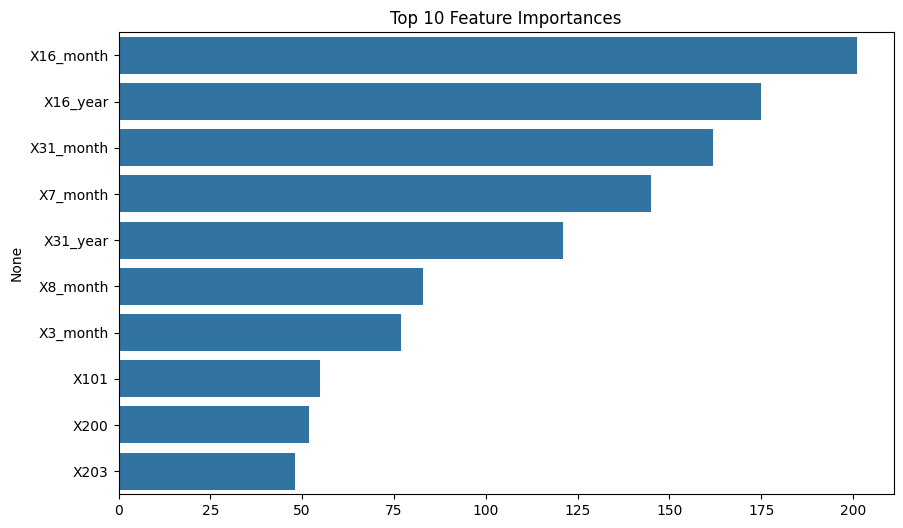

c:\Users\hp\Desktop\Internship Assignments\DeepQ-AI\DeepQ-AI Hiring Process\deepq_ai_assignment1_data\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


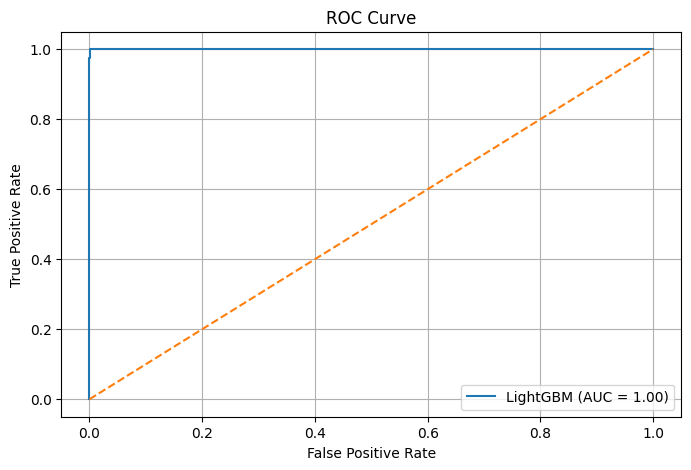

In [28]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    top_features = X.columns[indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=top_features)
    plt.title("Top 10 Feature Importances")
    plt.show()

if hasattr(best_model, "predict_proba"):
    y_probs = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc_score(y_test, y_probs):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
# Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestClassifier(), X, y, cv=5, scoring='roc_auc')
print("CV ROC-AUC scores:", scores)

CV ROC-AUC scores: [0.99996641 0.99994522 0.99985484 0.99992273 0.99978574]
